<center><h1><b><u> Multilayer Perceptron for MNIST Dataset From Scratch</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [221]:
import numpy as np
from operator import itemgetter
import random
import json
import pickle
import matplotlib.pyplot as plt
from PIL import Image

## __Loading the Data__

In [222]:
def extract_images(filename):
    '''Many file formats use magic numbers so that file readers can easily identify them to verify its reading correct file type. This prevents some errors. Each
    pixel is represented from value 0-255 (an unsigned byte/8 bit integer). Metadata is big endian (>, normal) and 4 byte/32 bit integer and stored as 1D array.
    file.read(x) takes x bytes from the file and creates an immutable buffer (a bytes object, an array of bytes) and stores it in memory. frombuffer interprets buffer object as array
    of bytes of certain data type. It doesn't copy the data just provides a view of the existing data and converts to numpy array.'''
    with open(filename, 'rb') as f: #read binary
        buffer = f.read(16) #metadata
        magic, num_images, rows, cols = np.frombuffer(buffer, dtype='>i4') #rows and columns per image (dimensions)
        data = np.frombuffer(f.read(), dtype=np.uint8) #read and store remaining data in 1D numpy array; #numpy spaces out elements instead of commas
        data = data.reshape(num_images, rows, cols).astype(np.float32) #reshape flat data into 3D, num_image amt of rows x cols arrays
    return data

def extract_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = np.frombuffer(f.read(8), dtype='>i4')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels] #certain row of the identity matrix

def load_mnist():
    data_path = '../data/MNIST/raw'
    train_images = extract_images(f'{data_path}/train-images-idx3-ubyte')
    train_labels = extract_labels(f'{data_path}/train-labels-idx1-ubyte')
    test_images = extract_images(f'{data_path}/t10k-images-idx3-ubyte')
    test_labels = extract_labels(f'{data_path}/t10k-labels-idx1-ubyte')

    #Make sure data is right shape for forward pass
    train_images_flat = train_images.reshape(60000, 784).T
    test_images_flat = test_images.reshape(10000, 784).T

    train_labels_one_hot = one_hot_encode(train_labels).T
    test_labels_one_hot = one_hot_encode(test_labels).T
    
    return (train_images_flat, train_labels_one_hot), (test_images_flat, test_labels_one_hot) #each dataset is tuple of numpy arrays

In [223]:
#Comma means tuple containing 1 element otherwise would just be int; numpy arrays come with useful attributes like shape
(train_images, train_labels), (test_images, test_labels) = load_mnist()

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (784, 60000)
Train labels shape: (10, 60000)
Test images shape: (784, 10000)
Test labels shape: (10, 10000)


## __Viewing a Sample__

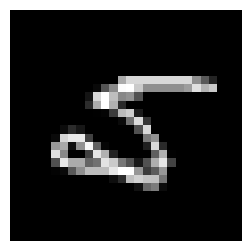

In [224]:
index = random.randrange(0, train_images.shape[1])

plt.figure(figsize=(6, 3))
plt.imshow(train_images[:, index].reshape(28,28), cmap = 'gray')
plt.axis("off")
plt.show()

## __Initializing the Hyperparameters__

In [225]:
class Hypers:
    def __init__(self, hyperpath):
        with open(hyperpath, 'r') as file:
            hyper_dict = json.load(file)
        self.lr = hyper_dict['learning_rate']
        self.b_size = hyper_dict['batch_size']
        self.n_slope = hyper_dict['n_slope']
        self.epochs = hyper_dict['epochs']
        self.hidden = hyper_dict['hidden']


#can feed this into functions that need hypers
hypers = Hypers('../config/mlp-scratch-hyperparameters.json')

## __Defining Functions__

### __Activations__

In [226]:
def softmax(x): #x is vector
    # Subtract max for numerical stability, keeping dims for proper broadcasting; axis = 0 is all elements you can reach by varying first index (row), which is a column
    x_shifted = x - np.max(x, axis=0, keepdims=True)
    
    # Compute exponentials
    exp_x = np.exp(x_shifted)
    
    # Compute softmax
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

In [227]:
def relu(z):
    return np.maximum(z, 0)

In [228]:
def drelu_dz(z):
    return np.where(z <= 0, 0.0, 1.0).astype(np.float32)

### __Parameter Initialization__

In [229]:
def he_init(shape):
    #output, input
    fan_out, fan_in = shape
    
    #scaling factor; 2 for ReLU
    scaling = np.sqrt(2/fan_in)

    #create matrix sampled from Gaussian and multiply by scaling factor
    return np.random.randn(fan_out, fan_in) * scaling

## __Model Structure__

### __Average Loss Function for Categorical Cross-Entropy__

In [230]:
class AvgCategoricalCrossEntropy:
    #loss function
    def __call__(self, A2, Y):
        m = Y.shape[1]
        
        epsilon=1e-15
        A2_safe = np.maximum(A2, epsilon)

        #same as doing (1/m) * sum of all columns (sum of values in a column of Y * np.log(A2_safe)); (1/m) total loss across whole batch
        return (-1/m) * np.sum(Y * np.log(A2_safe)) 
    

    def backward(self, X, Y, parameters, layer_computations):
        W1, b1, W2, b2 = parameters
        Z1, A1, Z2, A2 = layer_computations

        m = X.shape[1] #batch size

        dZ2 = (A2 - Y)
        dW2 = (1/m)*(dZ2 @ A1.T)
        db2 = (1/m)*np.sum(dZ2, axis = 1, keepdims = True) #sums across each row for all rows (summing the columns)

        dZ1 = (W2.T @ dZ2)*drelu_dz(Z1) 
        dW1 = (1/m)*(dZ1 @ X.T)
        db1 = (1/m)*np.sum(dZ1, axis = 1, keepdims = True)


        #{'dW1': dW1, 'db1': db1, 'dW2' : dW2, 'db2': db2}
        return dW1, db1, dW2, db2

### __Optimizer__

In [231]:
class FullBatchGD: 
    def __init__(self, lr = 0.01):
        self.lr = lr

    def step(self, parameters, partials):
        #Unpack info
        W1, b1, W2, b2 = parameters
        dW1, db1, dW2, db2 = partials
        
        #Take step and update parameters in model object
        W1 = W1 - self.lr*dW1
        b1 = b1 - self.lr*db1
        W2 = W2 - self.lr*dW2
        b2 = b2 - self.lr*db2

        return W1, b1, W2, b2

### __The MLP__

In [232]:
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        #Input to hidden
        self.W1 = he_init((hidden_dim, input_dim)) 
        self.b1 = he_init((hidden_dim, 1))

        #hidden to output
        self.W2 = he_init((output_dim, hidden_dim))
        self.b2 = he_init((output_dim, 1))
        
        self.parameters = self.W1, self.b1, self.W2, self.b2
    
    def update_parameters(self, updated_params):
            self.parameters = updated_params
            self.W1, self.b1, self.W2, self.b2 = updated_params #makes sure the parameter attributes update for their use in __call__
        
    #forward
    def __call__(self, X, view_prob = False):
        #input to hidden
        Z1 = self.W1 @ X + self.b1 
        A1 = relu(Z1)

        #Hidden to output
        Z2 = self.W2 @ A1 + self.b2

        #Calculate loss
        A2 = softmax(Z2)

        return Z1, A1, Z2, A2

In [233]:
input_dim = train_images.shape[0]
output_dim = train_labels.shape[0]

model = MLP(input_dim, hypers.hidden, output_dim)
categorical_cross = AvgCategoricalCrossEntropy()
optimizer = FullBatchGD(hypers.lr)

## __Training__

In [234]:
def train(model, X, Y, criterion, optimizer, hypers):
    avg_losses = []

    for epoch in range(hypers.epochs):
        #Forward pass
        layer_computations = model(X) #A2 column consists of probabilities of each class
        A2 = layer_computations[3]

        #Loss calculation
        avg_loss = criterion(A2, Y)

        #Backprop
        partials = criterion.backward(X, Y, model.parameters, layer_computations)

        #Gd
        updated_params = optimizer.step(model.parameters, partials) #right side is inputted into setter
        model.update_parameters(updated_params)

        avg_losses.append(avg_loss)

        if ((epoch+1)%10 == 0):
            print(f'Epoch {epoch + 1}, Loss: {avg_loss}')
    
    return model, avg_losses

In [235]:
model, avg_losses = train(model, train_images, train_labels, categorical_cross, optimizer, hypers)

Epoch 10, Loss: 2.2924005111599155
Epoch 20, Loss: 1.5243839800877306
Epoch 30, Loss: 1.1705383976609076
Epoch 40, Loss: 1.008894507419657
Epoch 50, Loss: 0.8554310344504444
Epoch 60, Loss: 0.7785705441934773
Epoch 70, Loss: 0.8025876191751885
Epoch 80, Loss: 0.6363102683260706


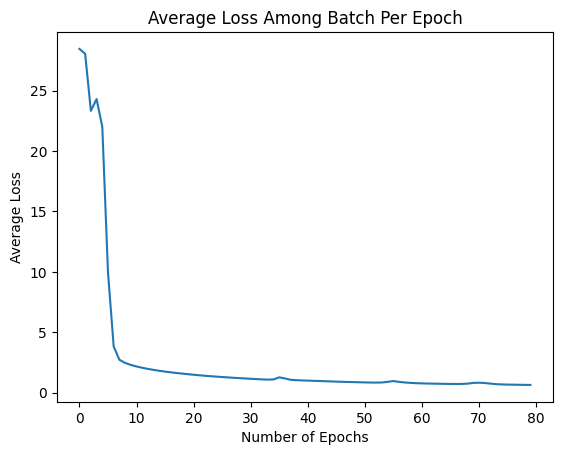

In [236]:
all_epochs = np.arange(0, hypers.epochs)
plt.plot(all_epochs, avg_losses)
plt.title("Average Loss Among Batch Per Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel("Average Loss")
plt.show()

## __Evaluation__

In [237]:
def evaluate(model, X, Y):    
    layer_computations = model(X)
    A2 = layer_computations[3]

    #Find max along column for prediction
    y_pred = np.argmax(A2, axis = 0) 
    y_truth = np.argmax(Y, axis = 0)

    acc = np.sum(y_pred == y_truth) / len(y_truth) * 100 #same as np.mean
    return acc

In [248]:
train_acc = evaluate(model, train_images, train_labels) 
test_acc = evaluate(model, test_images, test_labels) 


print(f'Train Accuracy: {train_acc:.2f}%')
print(f'Test Accuracy: {test_acc:.2f}%')

Train Accuracy: 85.47%
Test Accuracy: 84.59%


## __Pickling the Model__

In [246]:
f_name = "mlp-scratch-84.59.pkl"

In [240]:
#with open(f'../models/{f_name}', 'wb') as f:
    #pickle.dump(model, f)

In [247]:
# Loading the model
with open(f'../models/{f_name}', 'rb') as f:
    model = pickle.load(f)

## __Inference on New Image__

### __Preprocess and Visualizing Image__

In [249]:
#Normalize and change to proper dimension
def preprocess(image_path):
    #Resize and convert to numpy
    image = Image.open(image_path).convert('L')
    image = np.array(image.resize((28, 28)))
    
    im_normalized = image / 255.0
    
    return im_normalized.reshape(784, 1)

def preprocess_vis(image_path):
    image = Image.open(image_path).convert('L')
    return image.resize((28, 28))

In [299]:
image_path = '../data/test-images/6-2.png'

visual_im = preprocess_vis(image_path)

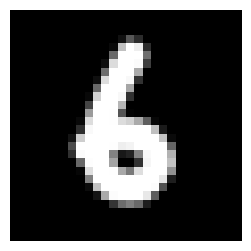

In [300]:
plt.figure(figsize=(6, 3))
plt.axis("off")

#Capture return value
_ = plt.imshow(visual_im, cmap="grey")

### __Feeding through MLP__

In [301]:
def classify_image(model, image_path):
    image = preprocess(image_path)


    layer_computations = model(image)
    A2 = layer_computations[3]

    #Extract and sort probabilities
    prob_classes = list(enumerate(A2[:, 0]))
    prob_classes.sort(key = itemgetter(1), reverse = True)

    #Extract classification
    y_pred = np.argmax(A2, axis = 0)[0] #Extract only element in the 1d array

    return prob_classes, y_pred

In [302]:
prob_classes, y_pred = classify_image(model, image_path)

for num, probability in prob_classes:
    print(f'Probability of {num}:{probability.item() * 100: .3f}%')

print(f'\nPredicted number: {y_pred}')

Probability of 8: 27.552%
Probability of 0: 22.281%
Probability of 4: 21.607%
Probability of 1: 19.706%
Probability of 3: 5.524%
Probability of 7: 1.590%
Probability of 5: 1.398%
Probability of 2: 0.266%
Probability of 6: 0.063%
Probability of 9: 0.013%

Predicted number: 8
